<a href="https://colab.research.google.com/github/SEC-API-io/sec-api-cookbook/blob/main/notebooks/form-144/form-144.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analysis of Form 144 Restricted Sales Notifications

This notebook demonstrates an exploratory data analysis examining notifications of restricted and control securities filed under SEC Rule 144 in SEC Form 144.

Since 2022, companies are required to file this form in XML format. Leveraging our [Form 144 - Restricted Sales Notification API](https://sec-api.io/docs/form-144-restricted-sales-api), we transform these disclosures into a standardized JSON format, facilitating comprehensive and efficient analysis.

Our analysis addresses several critical dimensions:

- Temporal trends in the number of Restricted Sales Notifications from 2022 to 2024, segmented by quarter, month, and intraday timing (pre-market, regular market hours, after-market).
- Distribution patterns across structured data fields, including the proportion of disclosures categorized by specific form types.
- Analysis of the proposed sales volume, including their distribution and temporal evolution.
- Timing of notification of sales
- Time between acquisition and sale


## Quick Start

To quickly retrieve data for a specific company, modify the following example as needed. For more detail, see [Form 144 - Restricted Sales Notification API](https://sec-api.io/docs/form-144-restricted-sales-api) and [sec-api-python package readme](https://github.com/janlukasschroeder/sec-api-python?tab=readme-ov-file#form-144---restricted-sales).


In [1]:
%pip install sec_api # use %pip for reliable install in current environment

In [2]:
# NOTE: Replace with your own API key
API_KEY_SEC_API = "YOUR_API_KEY"

In [3]:
from sec_api import Form144Api
import json

searchApi = Form144Api(api_key=API_KEY_SEC_API)

search_params = {
    "query": "issuerInfo.issuerCik:7431",
    "from": "0",
    "size": "1",
    "sort": [{"filedAt": {"order": "desc"}}],
}

# get proposed sales information, sales history, and other details
response = searchApi.get_data(search_params)
filing = response["data"]

print(json.dumps(filing, indent=2))

{
  "id": "a19d6a8949fb7292ed2acfbef53c2605",
  "accessionNo": "0001950047-24-005841",
  "fileNo": "001-02116",
  "formType": "144",
  "filedAt": "2024-08-06T16:19:52-04:00",
  "entities": [
    {
      "fiscalYearEnd": "1231",
      "stateOfIncorporation": "PA",
      "act": "33",
      "cik": "7431",
      "fileNo": "001-02116",
      "irsNo": "230366390",
      "companyName": "ARMSTRONG WORLD INDUSTRIES INC (Subject)",
      "type": "144",
      "sic": "3089 Plastics Products, NEC",
      "filmNo": "241179595",
      "undefined": "08 Industrial Applications and Services)"
    },
    {
      "cik": "1471798",
      "companyName": "Melville James Clinton (Reporting)",
      "type": "144"
    }
  ],
  "issuerInfo": {
    "issuerCik": "7431",
    "issuerName": "ARMSTRONG WORLD INDUSTRIES INC.",
    "secFileNumber": "001-02116",
    "issuerAddress": {
      "street1": "2500 Columbia Avenue",
      "city": "Lancaster",
      "stateOrCountry": "PA",
      "zipCode": "17603"
    },
    "iss

## Download Dataset

To load and prepare the dataset of over 70,000 offering statement filings from Forms 144 in since October 2022, we utilize the [Form 144 - Restricted Sales Notification API](https://sec-api.io/docs/form-144-restricted-sales-api).
The following code handles data loading and preparation by executing multiple download processes in parallel, significantly reducing downloading time.

Once downloaded, all data objects are saved in JSONL format to `./form-144-dataset.jsonl.gz`.

Downloading the data may take several minutes.


In [4]:
import sys
import os
import time
import random

# from multiprocessing import Pool # use in .py files only
from concurrent.futures import ThreadPoolExecutor

YEARS = range(2025, 2021, -1)  # from 2025 to 2022
TEMP_FILE_TEMPLATE = "./temp_file_form_144_{}.jsonl"
TARGET_FILE = "./form-144-dataset.jsonl.gz"


def process_year(year):
    backoff_time = random.randint(10, 800) / 1000
    print(f"Starting year {year} with backoff time {backoff_time:,}s")
    sys.stdout.flush()
    time.sleep(backoff_time)

    tmp_filename = TEMP_FILE_TEMPLATE.format(year)
    tmp_file = open(tmp_filename, "a")

    for month in range(12, 0, -1):
        search_from = 0
        month_counter = 0

        while True:
            query = f"filedAt:[{year}-{month:02d}-01 TO {year}-{month:02d}-31]"
            searchRequest = {
                "query": query,
                "from": search_from,
                "size": "50",
                "sort": [{"filedAt": {"order": "desc"}}],
            }

            response = None
            try:
                response = Form144Api.get_data(searchRequest)
            except Exception as e:
                print(f"{year}-{month:02d} error: {e}")
                sys.stdout.flush()
                continue

            if response == None or len(response["data"]) == 0:
                break

            search_from += 50
            month_counter += len(response["data"])
            jsonl_data = "\n".join([json.dumps(entry) for entry in response["data"]])
            tmp_file.write(jsonl_data + "\n")

        print(f"Finished loading {month_counter} filings for {year}-{month:02d}")
        sys.stdout.flush()

    tmp_file.close()

    return year


if not os.path.exists(TARGET_FILE):
    with ThreadPoolExecutor(max_workers=4) as pool:
        processed_years = list(pool.map(process_year, YEARS))
    print("Finished processing all years.", processed_years)

    # merge the temporary files into one final file
    with open(TARGET_FILE, "a") as outfile:
        for year in YEARS:
            temp_file = TEMP_FILE_TEMPLATE.format(year)
            if os.path.exists(temp_file):
                with open(temp_file, "r") as infile:
                    outfile.write(infile.read())
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


## Analyzing Data


In [5]:
# install all dependencies required for the notebook
# %pip install pandas numpy matplotlib seaborn

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
import seaborn as sns

style.use("default")

params = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.color": "grey",
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.alpha": 0.5,
    "grid.linestyle": ":",
}

plt.rcParams.update(params)

form_name = "Form 144"
form_name_escaped = "form-144"

In [7]:
structured_data = pd.read_json(TARGET_FILE, lines=True)
structured_data = pd.json_normalize(structured_data.to_dict(orient="records"))

structured_data["filedAt"] = pd.to_datetime(structured_data["filedAt"], utc=True)
structured_data["filedAt"] = structured_data["filedAt"].dt.tz_convert("US/Eastern")
structured_data = structured_data.sort_values("filedAt", ascending=True).reset_index(
    drop=True
)

# there are two filings per accession number for Form 144
# if you want to access individual company information, comment out the following line
# structured_data.drop_duplicates("accessionNo", keep="first", inplace=True)
structured_data["year"] = structured_data["filedAt"].dt.year
structured_data["month"] = structured_data["filedAt"].dt.month
structured_data["qtr"] = structured_data["month"].apply(lambda x: (x - 1) // 3 + 1)
structured_data["dayOfWeek"] = structured_data["filedAt"].dt.day_name()
# filedAtClass: preMarket (4:00AM-9:30AM), regularMarket (9:30AM-4:00PM), afterMarket (4:00PM-8:00PM)
structured_data["filedAtClass"] = structured_data["filedAt"].apply(
    lambda x: (
        "preMarket"
        if x.hour < 9 or (x.hour == 9 and x.minute < 30)
        else (
            "regularMarket"
            if x.hour < 16
            else "afterMarket" if x.hour < 20 else "other"
        )
    )
)

structured_data.head()

,id,accessionNo,fileNo,formType,filedAt,entities,securitiesInformation,securitiesToBeSold,nothingToReportFlagOnSecuritiesSoldInPast3Months,securitiesSoldInPast3Months,...,issuerInfo.issuerTicker,noticeSignature.noticeDate,noticeSignature.signature,noticeSignature.planAdoptionDates,issuerInfo.issuerAddress.street2,year,month,qtr,dayOfWeek,filedAtClass
0,f2ce9febeff7a9b6e879a4363b739587,0001921094-22-000004,001-15525,144,2022-10-07 14:02:22-04:00,"[{'fiscalYearEnd': '1231', 'stateOfIncorporati...","[{'securitiesClassTitle': 'Common', 'brokerOrM...","[{'securitiesClassTitle': 'Common', 'acquiredD...",False,"[{'sellerDetails': {'name': 'HUIMIN WANG', 'ad...",...,EW,10/07/2022,HUIMIN WANG,[02/04/2022],NaN,2022,10,4,Friday,regularMarket
1,567dd75f17174c76d37f00bedfa4c735,0000107476-22-000007,000-54296,144,2022-10-07 15:28:02-04:00,"[{'fiscalYearEnd': '0630', 'stateOfIncorporati...","[{'securitiesClassTitle': 'Common', 'brokerOrM...","[{'securitiesClassTitle': 'Common', 'acquiredD...",True,NaN,...,AXIM,10/06/2022,Blake N Schroeder,[09/21/2022],SUITE 114,2022,10,4,Friday,regularMarket
2,7ef0c9ab185899ca8a1d41d6f920638c,0001921094-22-000006,001-37824,144,2022-10-13 15:33:54-04:00,"[{'fiscalYearEnd': '1231', 'stateOfIncorporati...","[{'securitiesClassTitle': 'Common', 'brokerOrM...","[{'securitiesClassTitle': 'Common', 'acquiredD...",False,"[{'sellerDetails': {'name': 'CARY BAKER', 'add...",...,PI,10/13/2022,CARY BAKER,NaN,SUITE 1200,2022,10,4,Thursday,regularMarket
3,3ad3feb808dea5da2ee6c92173f4caf2,0001921094-22-000008,001-37824,144,2022-10-13 15:42:36-04:00,"[{'fiscalYearEnd': '1231', 'stateOfIncorporati...","[{'securitiesClassTitle': 'Common', 'brokerOrM...","[{'securitiesClassTitle': 'Common', 'acquiredD...",False,"[{'sellerDetails': {'name': 'CHRIS DIORIO', 'a...",...,PI,10/13/2022,CHRIS DIORIO,NaN,SUITE 1200,2022,10,4,Thursday,regularMarket
4,f86981868a5c6b61555386db9ff54aa6,0001921094-22-000010,001-37824,144,2022-10-13 15:47:35-04:00,"[{'fiscalYearEnd': '1231', 'stateOfIncorporati...","[{'securitiesClassTitle': 'Common', 'brokerOrM...","[{'securitiesClassTitle': 'Common', 'acquiredD...",False,"[{'sellerDetails': {'name': 'JEFF DOSSETT', 'a...",...,PI,10/13/2022,JEFF DOSSETT,NaN,SUITE 1200,2022,10,4,Thursday,regularMarket


In [8]:
accNoToInsiderAndIssuer = {}
for idx, row in structured_data.iterrows():
    accNo = row["accessionNo"]
    entities = row["entities"]
    issuerCik = row["issuerInfo.issuerCik"]
    issuerName = row["issuerInfo.issuerName"]
    accNoToInsiderAndIssuer[accNo] = {}
    for entity in entities:
        if entity["cik"] == issuerCik:
            accNoToInsiderAndIssuer[accNo].update(
                {
                    "issuerName": entity["companyName"],
                    "issuerCik": entity["cik"],
                }
            )
        else:
            accNoToInsiderAndIssuer[accNo].update(
                {
                    "insiderName": entity["companyName"],
                    "insiderCik": entity["cik"],
                }
            )

In [9]:
structured_data["issuerCik"] = structured_data["accessionNo"].apply(
    lambda x: accNoToInsiderAndIssuer[x]["issuerCik"]
)
structured_data["issuerName"] = structured_data["accessionNo"].apply(
    lambda x: accNoToInsiderAndIssuer[x]["issuerName"]
)
structured_data["insiderCik"] = structured_data["accessionNo"].apply(
    lambda x: accNoToInsiderAndIssuer.get(x, {}).get("insiderCik", np.nan)
)
structured_data["insiderName"] = structured_data["accessionNo"].apply(
    lambda x: accNoToInsiderAndIssuer.get(x, {}).get("insiderName", np.nan)
)

In [10]:
unique_years = structured_data["year"].nunique()
unique_issuers = structured_data["issuerCik"].nunique()
unique_insiders = structured_data["insiderCik"].nunique()
unique_insider_names = structured_data["insiderName"].nunique()
unique_filings = structured_data["accessionNo"].nunique()
unique_tickers = structured_data["issuerInfo.issuerTicker"].nunique()
min_year = structured_data["year"].min()
max_year = structured_data["year"].max()
max_year_full = max_year - 1  # to avoid incomplete data for the current year
print(f"Loaded dataframe with main documents of {form_name} filings")
print(f"Number of filings: {unique_filings:,}")
print(f"Number of records: {len(structured_data):,}")
print(f"Number of years: {unique_years:,} ({min_year}-{max_year})")
# print(f"Number of unique companies: {unique_companies:,}")
print(f"Number of unique issuers: {unique_issuers:,}")
print(f"Number of unique insider ciks: {unique_insiders:,}")
print(f"Number of unique insider names: {unique_insider_names:,}")
print(f"Number of unique ticker symbols found: {unique_tickers:,}")

structured_data.head()

Loaded dataframe with main documents of Form 144 filings
Number of filings: 70,997
Number of records: 70,997
Number of years: 4 (2022-2025)
Number of unique issuers: 3,578
Number of unique insider ciks: 17,431
Number of unique insider names: 17,438
Number of unique ticker symbols found: 3,518


,id,accessionNo,fileNo,formType,filedAt,entities,securitiesInformation,securitiesToBeSold,nothingToReportFlagOnSecuritiesSoldInPast3Months,securitiesSoldInPast3Months,...,issuerInfo.issuerAddress.street2,year,month,qtr,dayOfWeek,filedAtClass,issuerCik,issuerName,insiderCik,insiderName
0,f2ce9febeff7a9b6e879a4363b739587,0001921094-22-000004,001-15525,144,2022-10-07 14:02:22-04:00,"[{'fiscalYearEnd': '1231', 'stateOfIncorporati...","[{'securitiesClassTitle': 'Common', 'brokerOrM...","[{'securitiesClassTitle': 'Common', 'acquiredD...",False,"[{'sellerDetails': {'name': 'HUIMIN WANG', 'ad...",...,NaN,2022,10,4,Friday,regularMarket,1099800,Edwards Lifesciences Corp (Subject),1204553,WANG HUIMIN (Reporting)
1,567dd75f17174c76d37f00bedfa4c735,0000107476-22-000007,000-54296,144,2022-10-07 15:28:02-04:00,"[{'fiscalYearEnd': '0630', 'stateOfIncorporati...","[{'securitiesClassTitle': 'Common', 'brokerOrM...","[{'securitiesClassTitle': 'Common', 'acquiredD...",True,NaN,...,SUITE 114,2022,10,4,Friday,regularMarket,1514946,"AXIM BIOTECHNOLOGIES, INC. (Subject)",107476,"WILSON-DAVIS & CO., INC. (Reporting)"
2,7ef0c9ab185899ca8a1d41d6f920638c,0001921094-22-000006,001-37824,144,2022-10-13 15:33:54-04:00,"[{'fiscalYearEnd': '1231', 'stateOfIncorporati...","[{'securitiesClassTitle': 'Common', 'brokerOrM...","[{'securitiesClassTitle': 'Common', 'acquiredD...",False,"[{'sellerDetails': {'name': 'CARY BAKER', 'add...",...,SUITE 1200,2022,10,4,Thursday,regularMarket,1114995,IMPINJ INC (Subject),1705407,Baker Cary (Reporting)
3,3ad3feb808dea5da2ee6c92173f4caf2,0001921094-22-000008,001-37824,144,2022-10-13 15:42:36-04:00,"[{'fiscalYearEnd': '1231', 'stateOfIncorporati...","[{'securitiesClassTitle': 'Common', 'brokerOrM...","[{'securitiesClassTitle': 'Common', 'acquiredD...",False,"[{'sellerDetails': {'name': 'CHRIS DIORIO', 'a...",...,SUITE 1200,2022,10,4,Thursday,regularMarket,1114995,IMPINJ INC (Subject),1677721,DIORIO CHRIS PH.D. (Reporting)
4,f86981868a5c6b61555386db9ff54aa6,0001921094-22-000010,001-37824,144,2022-10-13 15:47:35-04:00,"[{'fiscalYearEnd': '1231', 'stateOfIncorporati...","[{'securitiesClassTitle': 'Common', 'brokerOrM...","[{'securitiesClassTitle': 'Common', 'acquiredD...",False,"[{'sellerDetails': {'name': 'JEFF DOSSETT', 'a...",...,SUITE 1200,2022,10,4,Thursday,regularMarket,1114995,IMPINJ INC (Subject),1578147,DOSSETT JEFFREY (Reporting)


In [11]:
structured_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70997 entries, 0 to 70996
Data columns (total 36 columns):
 #   Column                                                          Non-Null Count  Dtype                     
---  ------                                                          --------------  -----                     
 0   id                                                              70997 non-null  object                    
 1   accessionNo                                                     70997 non-null  object                    
 2   fileNo                                                          70983 non-null  object                    
 3   formType                                                        70997 non-null  object                    
 4   filedAt                                                         70997 non-null  datetime64[ns, US/Eastern]
 5   entities                                                        70997 non-null  object                

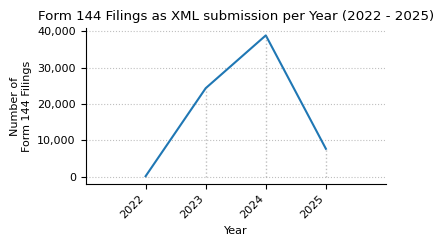

In [12]:
def plot_timeseries(ts, title, key="count"):
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ts[key].plot(ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel(f"Number of\n{form_name} Filings")
    ax.set_xticks(np.arange(min_year, max_year + 1, 1))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.set_xlim(min_year - 1, max_year + 1)
    ax.grid(axis="x")
    ax.set_axisbelow(True)
    plt.xticks(rotation=45, ha="right")

    for year in range(min_year, max_year + 1, 1):
        year_y_max = ts.loc[year, key]
        ax.vlines(year, 0, year_y_max, linestyles=":", colors="grey", alpha=0.5, lw=1)

    plt.tight_layout()
    plt.show()


filing_counts = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year"])
    .size()
    .to_frame(name="count")
)

plot_timeseries(
    filing_counts,
    title=f"{form_name} Filings as XML submission per Year ({min_year} - {max_year})",
)

In [13]:
count_formType = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["formType"])
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Count")
).rename_axis("Submission Type")
count_formType["Pct"] = (
    count_formType["Count"].astype(int) / count_formType["Count"].astype(int).sum()
).map("{:.0%}".format)
count_formType["Count"] = count_formType["Count"].map(lambda x: f"{x:,}")

print(f"{form_name} Disclosures by Submission Type ({min_year} - {max_year})")
count_formType

Form 144 Disclosures by Submission Type (2022 - 2025)


,Count,Pct
Submission Type,,
144,"70,081",99%
144/A,916,1%


In [14]:
form_counts_by_type_and_year = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year", "formType"])
    .size()
    .to_frame(name="count")
    .unstack(fill_value=0)
)

form_counts_by_type_and_year.loc["Total"] = form_counts_by_type_and_year.sum()
form_counts_by_type_and_year["Total"] = form_counts_by_type_and_year.sum(axis=1)


print(f"{form_name} counts from {min_year} to {max_year}.")
form_counts_by_type_and_year

Form 144 counts from 2022 to 2025.


count        Total
formType    144 144/A       
year                        
2022         88     1     89
2023      23968   383  24351
2024      38458   454  38912
2025       7567    78   7645
Total     70081   916  70997

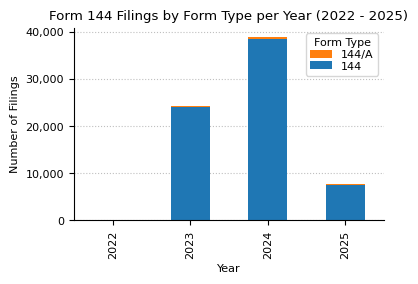

In [15]:
fig, ax = plt.subplots(figsize=(4, 2.5))
form_counts_by_type_and_year["count"].drop("Total").plot(
    kind="bar", stacked=True, ax=ax
)
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    list(reversed(handles)),
    list(reversed(labels)),
    title="Form Type",
    labelspacing=0.15,
)
ax.set_title(f"{form_name} Filings by Form Type per Year ({min_year} - {max_year})")
plt.show()

In [16]:
counts_qtr_yr_piv = (
    structured_data.groupby(["year", "qtr"]).size().unstack().fillna(0)
).astype(int)

print(f"{form_name} counts by quarter from {min_year} to {max_year}.")
counts_qtr_yr_piv.T

Form 144 counts by quarter from 2022 to 2025.


year,2022,2023,2024,2025
qtr,,,,
1,0,621,10907,7645
2,0,7329,8705,0
3,0,8252,9090,0
4,89,8149,10210,0


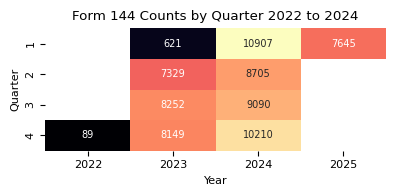

In [17]:
plt.figure(figsize=(4, 2))
sns.heatmap(
    counts_qtr_yr_piv.T,
    annot=True,  # Display the cell values
    fmt="d",  # Integer formatting
    cmap="magma",  # Color map
    cbar_kws={"label": "Count"},  # Colorbar label
    mask=counts_qtr_yr_piv.T == 0,  # Mask the cells with value 0
    cbar=False,
    annot_kws={"fontsize": 7},
)
plt.grid(False)
plt.title(f"{form_name} Counts by Quarter {min_year} to {max_year_full}")
plt.xlabel("Year")
plt.ylabel("Quarter")
plt.tight_layout()
plt.show()

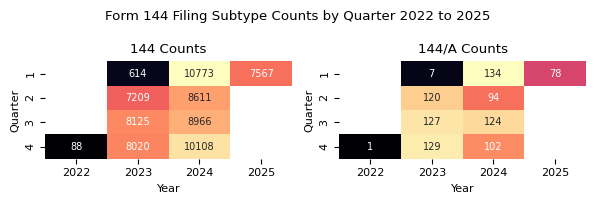

In [18]:
form_types = count_formType.index.tolist()

fig, axes = plt.subplots(1, 2, figsize=(6, 2))

cnt = 0
for formType in form_types:
    data = (
        structured_data[structured_data["formType"] == formType]
        .groupby(["year", "qtr"])
        .size()
        .unstack()
        .fillna(0)
        .astype(int)
        .reindex(columns=range(1, 5), fill_value=0)  # ensure all month are included
    )

    filing_name = formType
    # if data.sum().sum() < 100:
    #     continue

    ax = axes.flatten()[cnt]

    sns.heatmap(
        data.T,
        ax=ax,
        annot=True,  # Display the cell values
        fmt="d",  # Integer formatting
        cmap="magma",  # Color map
        cbar_kws={"label": "Count"},  # Colorbar label
        mask=data.T == 0,  # Mask the cells with value 0
        cbar=False,
        annot_kws={"fontsize": 7},
    )
    ax.grid(False)
    ax.set_title(f"{filing_name} Counts")
    ax.set_xlabel("Year")
    ax.set_ylabel("Quarter")

    cnt += 1

fig.suptitle(f"{form_name} Filing Subtype Counts by Quarter {min_year} to {max_year}")
plt.tight_layout()

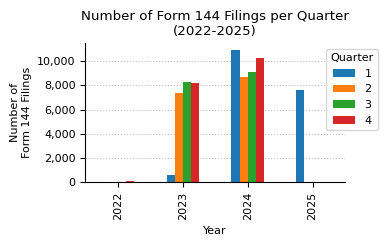

In [19]:
counts_qtr_yr = counts_qtr_yr_piv.stack().reset_index(name="count")

fig, ax = plt.subplots(figsize=(4, 2.5))
counts_qtr_yr_piv.plot(kind="bar", ax=ax, legend=True)
ax.legend(title="Quarter", loc="upper right", bbox_to_anchor=(1.15, 1))
ax.set_title(f"Number of {form_name} Filings per Quarter\n({min_year}-{max_year})")
ax.set_xlabel("Year")
ax.set_ylabel(f"Number of\n{form_name} Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

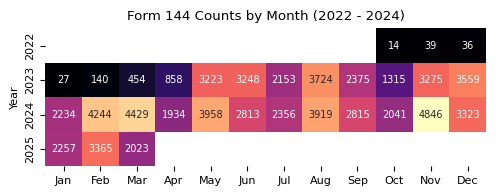

In [20]:
counts_month_yr_piv = (
    structured_data.groupby(["year", "month"]).size().unstack().fillna(0)
).astype(int)

plt.figure(figsize=(5, 2))
sns.heatmap(
    counts_month_yr_piv,
    annot=True,
    fmt="d",
    cmap="magma",
    cbar_kws={"label": "Count"},
    mask=counts_month_yr_piv == 0,
    cbar=False,
    annot_kws={"size": 7},
)
# convert x-labels to month names: 1 => Jan, 2 => Feb, etc.
plt.xticks(
    ticks=np.arange(0.5, 12.5, 1),
    labels=[pd.to_datetime(str(i), format="%m").strftime("%b") for i in range(1, 13)],
)
plt.grid(False)
plt.title(f"{form_name} Counts by Month ({min_year} - {max_year_full})")
plt.xlabel("")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

In [21]:
print(
    f"Descriptive statistics for {form_name} filing counts by month from {min_year} to {max_year}."
)
month_stats = (
    counts_month_yr_piv.loc[2004:]
    .describe(percentiles=[0.025, 0.975])
    .round(0)
    .astype(int)
)
month_stats

Descriptive statistics for Form 144 filing counts by month from 2022 to 2025.


month,1,2,3,4,5,6,7,8,9,10,11,12
count,4,4,4,4,4,4,4,4,4,4,4,4
mean,1130,1937,1726,698,1795,1515,1127,1911,1298,842,2040,1730
std,1289,2187,1999,918,2095,1759,1304,2208,1509,1009,2420,1979
min,0,0,0,0,0,0,0,0,0,0,0,0
2.5%,2,11,34,0,0,0,0,0,0,1,3,3
50%,1130,1752,1238,429,1612,1406,1076,1862,1188,664,1657,1680
97.5%,2255,4178,4249,1853,3903,3215,2341,3904,2782,1987,4728,3541
max,2257,4244,4429,1934,3958,3248,2356,3919,2815,2041,4846,3559


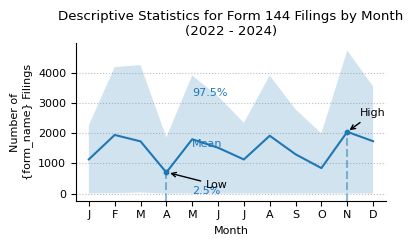

In [22]:
def plot_box_plot_as_line(
    data: pd.DataFrame,
    x_months=True,
    title="",
    x_label="",
    x_pos_mean_label=2,
    pos_labels=None,
    pos_high_low=None,
    y_label="",
    y_formatter=lambda x, p: "{:.0f}".format(int(x) / 1000),
    show_high_low_labels=True,
    show_inline_labels=True,
    show_bands=True,
    figsize=(4, 2.5),
    line_source="mean",
):
    fig, ax = plt.subplots(figsize=figsize)

    line_to_plot = data[line_source]
    lower_label = "2.5%"
    upper_label = "97.5%"
    lower = data[lower_label]
    upper = data[upper_label]

    line_to_plot.plot(ax=ax)

    if show_bands:
        ax.fill_between(line_to_plot.index, lower, upper, alpha=0.2)

    if x_months:
        ax.set_xlim(0.5, 12.5)
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_formatter))
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

    ymin, ymax = ax.get_ylim()
    y_scale = ymax - ymin

    max_x = int(line_to_plot.idxmax())
    max_y = line_to_plot.max()
    min_x = int(line_to_plot.idxmin())
    min_y = line_to_plot.min()

    ax.axvline(
        max_x,
        ymin=0,
        ymax=((max_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(max_x, max_y, color="tab:blue", s=10)
    ax.axvline(
        min_x,
        ymin=0,
        ymax=((min_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(min_x, min_y, color="tab:blue", s=10)

    x_pos_mean_label_int = int(x_pos_mean_label)
    if show_inline_labels:
        mean_x = x_pos_mean_label
        mean_y = line_to_plot.iloc[x_pos_mean_label_int] * 1.02
        upper_x = x_pos_mean_label
        upper_y = upper.iloc[x_pos_mean_label_int]
        lower_x = x_pos_mean_label
        lower_y = lower.iloc[x_pos_mean_label_int] * 0.95

        if pos_labels:
            mean_x = pos_labels["mean"]["x"]
            mean_y = pos_labels["mean"]["y"]
            upper_x = pos_labels["upper"]["x"]
            upper_y = pos_labels["upper"]["y"]
            lower_x = pos_labels["lower"]["x"]
            lower_y = pos_labels["lower"]["y"]

        ax.text(mean_x, mean_y, "Mean", color="tab:blue", fontsize=8)
        ax.text(upper_x, upper_y, upper_label, color="tab:blue", fontsize=8)
        ax.text(lower_x, lower_y, lower_label, color="tab:blue", fontsize=8)

    if show_high_low_labels:
        high_x_origin = max_x
        high_y_origin = max_y
        high_x_label = high_x_origin + 0.5
        high_y_label = high_y_origin + 0.1 * y_scale
        if pos_high_low:
            high_x_label = pos_high_low["high"]["x"]
            high_y_label = pos_high_low["high"]["y"]
        ax.annotate(
            "High",
            (high_x_origin, high_y_origin),
            xytext=(high_x_label, high_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

        low_x_origin = min_x * 1.01
        low_y_origin = min_y
        low_x_label = low_x_origin + 1.5
        low_y_label = low_y_origin - 0.1 * y_scale
        if pos_high_low:
            low_x_label = pos_high_low["low"]["x"]
            low_y_label = pos_high_low["low"]["y"]
        ax.annotate(
            "Low",
            (low_x_origin, low_y_origin),
            xytext=(low_x_label, low_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

    ax.grid(axis="x")
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()


plot_box_plot_as_line(
    data=month_stats.T,
    title=f"Descriptive Statistics for {form_name} Filings by Month\n({min_year} - {max_year_full})",
    x_label="Month",
    y_label="Number of\n{form_name} Filings",
    y_formatter=lambda x, p: "{:.0f}".format(int(x)),
    x_pos_mean_label=5,
)

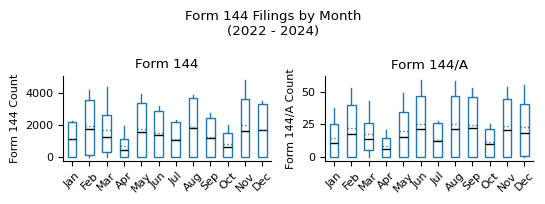

In [23]:
form_types = count_formType.index.tolist()

fig, axes = plt.subplots(1, 2, figsize=(5.5, 2))

cnt = 0
for formType in form_types:

    data = (
        structured_data[structured_data["formType"] == formType]
        .groupby(["year", "month"])
        .size()
        .unstack()
        .fillna(0)
        .reindex(columns=range(1, 13), fill_value=0)  # ensure all month are included
    )

    # if data.sum().sum() < 100:
    #     continue

    ax = axes.flatten()[cnt]
    cnt += 1
    try:
        data.boxplot(
            ax=ax,
            grid=False,
            showfliers=False,
            flierprops=dict(marker="o", markersize=3),
            patch_artist=True,
            boxprops=dict(facecolor="white", color="tab:blue"),
            showmeans=True,
            meanline=True,
            meanprops={"color": "tab:blue", "linestyle": ":"},
            medianprops={"color": "black"},
            capprops={"color": "none"},
        )

        ax.set_title(f"Form {formType}")
        ax.set_xlabel("")
        ax.set_ylabel(f"Form {formType} Count")
        xticklabels = [
            pd.to_datetime(str(x), format="%m").strftime("%b") for x in range(1, 13)
        ]
        ax.set_xticklabels(xticklabels)
        ax.tick_params(axis="x", rotation=45)
    except Exception as e:
        print(f"Error: {e}")

# disable the empty subplots
for i in range(cnt, len(axes.flatten())):
    axes.flatten()[i].axis("off")

fig.suptitle(f"{form_name} Filings by Month\n({min_year} - {max_year_full})")
plt.tight_layout()
plt.show()

In [24]:
counts_per_month_by_formType = (
    structured_data[["year", "month", "accessionNo", "formType"]]
    .groupby(["year", "month", "formType"])
    .count()
    .rename(columns={"accessionNo": "count"})
    .pivot_table(
        index=["year", "month"],  # Rows
        columns="formType",  # Columns
        values="count",  # Values to fill
        fill_value=0,  # Replace NaN with 0
    )
    .astype(int)
    .reset_index()  # Make year and month normal columns
)

counts_per_month_by_formType

formType,year,month,144,144/A
0,2022,10,14,0
1,2022,11,39,0
2,2022,12,35,1
3,2023,1,27,0
4,2023,2,140,0
5,2023,3,447,7
6,2023,4,846,12
7,2023,5,3174,49
8,2023,6,3189,59
9,2023,7,2128,25


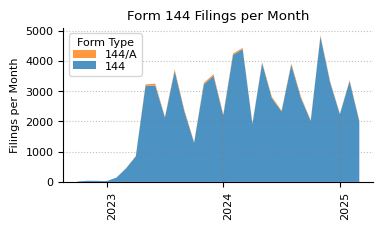

In [25]:
fix, ax = plt.subplots(figsize=(4, 2))

ax.stackplot(
    counts_per_month_by_formType["year"].astype(str)
    + "-"
    + counts_per_month_by_formType["month"].astype(str),
    *[counts_per_month_by_formType[ft] for ft in form_types],
    labels=[f"{ft}" for ft in form_types],
    alpha=0.8,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    list(reversed(handles)),
    list(reversed(labels)),
    title="Form Type",
    labelspacing=0.15,
)

ax.set_title(f"{form_name} Filings per Month")
ax.set_ylabel("Filings per Month")
xticks = (
    counts_per_month_by_formType["year"].astype(str)
    + "-"
    + counts_per_month_by_formType["month"].astype(str)
)
ax.set_xticks([i for i, x in enumerate(xticks) if x.endswith("-1")])
ax.set_xticklabels(
    [label.get_text()[:4] for label in ax.get_xticklabels()], rotation=90, ha="left"
)

ax.grid(axis="y", linestyle=":", alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# draw vertical lines for each first month of the year, dotted, transparency 0.5,
# with height of the y value for the respective month
for year, month in counts_per_month_by_formType[["year", "month"]].values:
    if month == 1:
        ax.vlines(
            f"{year}-{month}",
            ymin=0,
            ymax=counts_per_month_by_formType[
                (counts_per_month_by_formType["year"] == year)
                & (counts_per_month_by_formType["month"] == month)
            ]
            .drop(columns=["year", "month"])
            .sum(axis=1),
            linestyle=":",
            alpha=0.5,
            color="grey",
        )

plt.show()

In [26]:
counts_filedAtClass = (
    (
        structured_data.drop_duplicates(subset=["accessionNo"])
        .groupby(["filedAtClass"])
        .size()
        .sort_values(ascending=False)
        .to_frame(name="Count")
    )
    .rename_axis("Publication Time")
    .sort_values("Count", ascending=True)
)
counts_filedAtClass["Pct"] = (
    counts_filedAtClass["Count"].astype(int)
    / counts_filedAtClass["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_filedAtClass["Count"] = counts_filedAtClass["Count"].map(lambda x: f"{x:,}")
counts_filedAtClass.index = (
    counts_filedAtClass.index.str.replace("preMarket", "Pre-Market (4:00 - 9:30 AM)")
    .str.replace("marketHours", "Market Hours (9:30 AM - 4:00 PM)")
    .str.replace("afterMarket", "After Market (4:00 - 8:00 PM)")
)
counts_filedAtClass = counts_filedAtClass.reindex(counts_filedAtClass.index[::-1])

print(
    f"{form_name} filing counts by pre-market, regular market hours,\n"
    f"and after-market publication time ({min_year} - {max_year_full})."
)
counts_filedAtClass

Form 144 filing counts by pre-market, regular market hours,
and after-market publication time (2022 - 2024).


,Count,Pct
Publication Time,,
After Market (4:00 - 8:00 PM),"46,775",66%
regularMarket,"19,532",28%
other,"2,615",4%
Pre-Market (4:00 - 9:30 AM),"2,075",3%


In [27]:
counts_dayOfWeek = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["dayOfWeek"])
    .size()
    .to_frame(name="Count")
).rename_axis("Day of the Week")
counts_dayOfWeek["Pct"] = (
    counts_dayOfWeek["Count"].astype(int) / counts_dayOfWeek["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_dayOfWeek["Count"] = counts_dayOfWeek["Count"].map(lambda x: f"{x:,}")

print(f"{form_name} filing counts by day of the week ({min_year} - {max_year}).")
counts_dayOfWeek.loc[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]]

Form 144 filing counts by day of the week (2022 - 2025).


,Count,Pct
Day of the Week,,
Monday,"15,389",22%
Tuesday,"15,498",22%
Wednesday,"13,461",19%
Thursday,"13,032",18%
Friday,"13,617",19%


## Type of Insider


In [28]:
counts_insider_type = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["issuerInfo.relationshipsToIssuer"])
    .size()
    .to_frame(name="Count")
).rename_axis("Insider Type")
counts_insider_type.sort_values("Count", ascending=False, inplace=True)
counts_insider_type["Pct"] = (
    counts_insider_type["Count"].astype(int)
    / counts_insider_type["Count"].astype(int).sum()
).map("{:.1%}".format)
counts_insider_type["Count"] = counts_insider_type["Count"].map(lambda x: f"{x:,}")

print(f"{form_name} filing counts by Insider Type ({min_year} - {max_year}).")
counts_insider_type.head(10)

Form 144 filing counts by Insider Type (2022 - 2025).


,Count,Pct
Insider Type,,
Officer,"47,725",67.2%
Director,"13,305",18.7%
Affiliate,"1,920",2.7%
10% Stockholder,"1,790",2.5%
Former Officer,737,1.0%
Shareholder,456,0.6%
Affiliated Entity,438,0.6%
Former Director,258,0.4%
Member of immediate family of any of the foregoing,246,0.3%


## Aggregate Sales Volume

In this section we analyze the aggregate value of the proposed sales. Please note that a filer might not actually exercise the sales proposed in the notifications but might exercise the sale within 90 days of the notification.


In [29]:
structured_data["proposedSalesAggregateValue"] = structured_data[
    "securitiesInformation"
].apply(lambda l: sum([float(v.get("aggregateMarketValue", 0)) for v in l]))

structured_data["maxStockPriceInAggregateValue"] = structured_data[
    "securitiesInformation"
].apply(
    lambda l: sum(
        [
            (
                float(v.get("aggregateMarketValue", 0))
                / float(v.get("noOfUnitsSold", np.nan))
                if float(v.get("noOfUnitsSold", np.nan)) > 0
                else 0
            )
            for v in l
        ]
    )
)

In [30]:
# need to filter because some filers specify market cap as aggregateMarketValue
# instead of the aggregate values of the shares they intend to sell
aggregate_value_threshold = 1000
plausible_aggregate_market_values = structured_data[
    structured_data["maxStockPriceInAggregateValue"] < aggregate_value_threshold
]

# this strategy likely excludes some legitimate filings, but it's a good starting point
# for a more accurate analysis, one could check the stock price at the time of filing
# and compare it with the aggregateMarketValue for the filings with high stock prices

print(
    f"Number of filers reporting aggregate market values corresponding"
    f" to stock prices above ${aggregate_value_threshold:,}:"
)
print(
    len(
        structured_data[
            structured_data["maxStockPriceInAggregateValue"]
            >= aggregate_value_threshold
        ]["accessionNo"]
        .apply(lambda x: x.split("-")[0])
        .unique()
    )
)

print("Total number of filers in Form 144 dataset:")
print(len(structured_data["accessionNo"].apply(lambda x: x.split("-")[0]).unique()))

print(
    f"Number of filings with aggregate market values corresponding"
    f" to stock prices above ${aggregate_value_threshold:,}:"
)
print(
    len(
        structured_data[
            structured_data["maxStockPriceInAggregateValue"]
            >= aggregate_value_threshold
        ]
    )
)

Number of filers reporting aggregate market values corresponding to stock prices above $1,000:
39
Total number of filers in Form 144 dataset:
1107
Number of filings with aggregate market values corresponding to stock prices above $1,000:
472


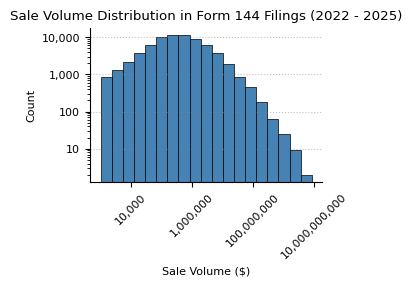

In [31]:
data = plausible_aggregate_market_values["proposedSalesAggregateValue"]

data = data[data > 1000]


def plot_hist(
    data,
    title,
    x_label,
    y_label,
    log_scale=False,
    xlog_scale=False,
    ylog_scale=False,
    bins=None,
    xticks=None,
):
    if log_scale:
        xlog_scale = True
        ylog_scale = True

    fig, ax = plt.subplots(figsize=(3, 2))

    if bins is None:
        if xlog_scale:
            bin_edges = np.logspace(np.log10(min(data)), np.log10(max(data)), num=20)
        else:
            bin_edges = bins
    else:
        bin_edges = bins

    ax.hist(
        data,
        bins=bin_edges,
        color="steelblue",
        edgecolor="black",
        linewidth=0.5,
    )

    if xticks is not None:
        ax.set_xticks(xticks)
    if log_scale:
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
        ax.tick_params(axis="x", rotation=45)
    if ylog_scale:
        ax.set_yscale("log")
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    return fig, ax


plot_hist(
    data,
    title=f"Sale Volume Distribution in {form_name} Filings ({min_year} - {max_year})",
    x_label="Sale Volume ($)",
    y_label="Count",
    log_scale=True,
)
plt.show()

In [32]:
# sort by proposedSalesAggregateValue and return the top 10
top_10_sales = plausible_aggregate_market_values.sort_values(
    "proposedSalesAggregateValue", ascending=False
).head(10)
print(
    f"Top 10 {form_name} Filings by Proposed Sales Aggregate Value ({min_year} - {max_year})."
)


top_10_sales[
    [
        "insiderName",
        "issuerName",
        "issuerInfo.issuerTicker",
        "proposedSalesAggregateValue",
        "maxStockPriceInAggregateValue",
        "filedAt",
    ]
].reset_index(drop=True).assign(
    proposedSalesAggregateValue=lambda x: x["proposedSalesAggregateValue"].map(
        "{:,.0f}".format
    ),
    maxStockPriceInAggregateValue=lambda x: x["maxStockPriceInAggregateValue"].map(
        "{:,.2f}".format
    ),
    filedAt=lambda x: x["filedAt"].dt.strftime("%Y-%m-%d"),
    insiderName=lambda x: x["insiderName"].str.replace(r" (Reporting)", ""),
    issuerName=lambda x: x["issuerName"].str.replace(r" (Subject)", ""),
).rename(
    columns={
        "insiderName": "Insider Name",
        "issuerName": "Issuer Name",
        "issuerInfo.issuerTicker": "Issuer Ticker",
        "proposedSalesAggregateValue": "Aggregate Value ($)",
        "maxStockPriceInAggregateValue": "Stock Price ($)",
        "filedAt": "Filed At",
    }
)

Top 10 Form 144 Filings by Proposed Sales Aggregate Value (2022 - 2025).


,Insider Name,Issuer Name,Issuer Ticker,Aggregate Value ($),Stock Price ($),Filed At
0,BEZOS JEFFREY P,AMAZON COM INC,AMZN,"8,457,500,000",169.15,2024-02-07
1,DEUTSCHE TELEKOM AG,"T-Mobile US, Inc.",TMUS,"5,801,501,826",361.38,2024-06-10
2,BEZOS JEFFREY P,AMAZON COM INC,AMZN,"4,930,000,000",197.20,2024-07-02
3,DEUTSCHE TELEKOM AG,"T-Mobile US, Inc.",TMUS,"3,595,927,501",155.71,2023-12-26
4,Mastercard Foundation,Mastercard Inc,MA,"3,583,008,000",459.36,2024-08-15
5,DEUTSCHE TELEKOM AG,"T-Mobile US, Inc.",TMUS,"3,310,419,375",164.76,2024-03-11
6,BEZOS JEFFREY P,AMAZON COM INC,AMZN,"3,048,501,168",186.40,2024-11-01
7,TD Luxembourg International Holdings S.a r.l.,SCHWAB CHARLES CORP,SCHW,"2,626,020,000",129.68,2024-08-21
8,Walton Family Holdings Trust,Walmart Inc.,WMT,"2,011,800,000",167.65,2023-11-17
9,Mastercard Foundation,Mastercard Inc,MA,"1,913,058,000",455.49,2024-05-10


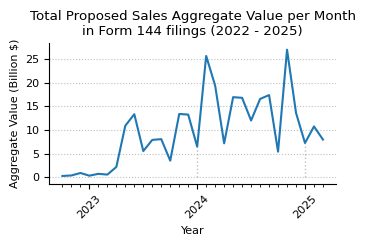

In [33]:
aggregate_value_per_month = (
    plausible_aggregate_market_values[["year", "month", "proposedSalesAggregateValue"]]
    .groupby(["year", "month"])
    .sum()
    .rename(columns={"accessionNo": "count"})
    .pivot_table(
        index=["year", "month"],  # Rows
        values="proposedSalesAggregateValue",  # Values to fill
        fill_value=0,  # Replace NaN with 0
    )
    .astype(int)
    .reset_index()  # Make year and month normal columns
)


def plot_timeseries_year_month(ts, title, key="count", multiplier=1, ylabel=None):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))

    # use first month of the year as major ticks and month as minor
    month_labels = aggregate_value_per_month["month"].astype(str)
    year_labels = aggregate_value_per_month["year"].astype(str)
    year_ticks = [n for n, m in enumerate(month_labels) if m == "1"]
    year_ticklabels = [y for y, m in zip(year_labels, month_labels) if m == "1"]

    values = ts[key] * multiplier

    ax.plot(range(len(values)), values)
    ax.set_title(title)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Year")
    ax.set_axisbelow(True)
    # set minor ticks for months
    ax.set_xticks(
        range(len(values)),
        minor=True,
    )
    ax.set_xticks(year_ticks, minor=False)
    ax.set_xticklabels(year_ticklabels)
    plt.xticks(rotation=45, va="top", ha="center")

    for year in ts["year"].unique():
        # get the maximum value for the year at month 1
        year_y_max = (
            ts.loc[(ts["year"] == year) & (ts["month"] == 1), key].max() * multiplier
        )
        x = ts.loc[ts["year"] == year, "month"].idxmin()
        ax.vlines(x, 0, year_y_max, linestyles=":", colors="grey", alpha=0.5, lw=1)

    plt.tight_layout()
    plt.show()


plot_timeseries_year_month(
    aggregate_value_per_month,
    title=f"Total Proposed Sales Aggregate Value per Month"
    f"\nin {form_name} filings ({min_year} - {max_year})",
    key="proposedSalesAggregateValue",
    multiplier=1e-9,
    ylabel="Aggregate Value (Billion $)",
)

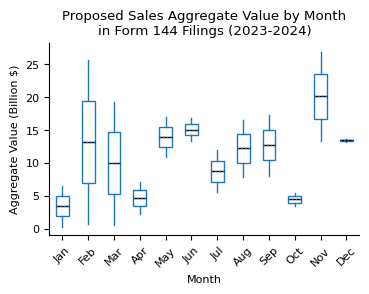

In [34]:
data = (
    plausible_aggregate_market_values[
        plausible_aggregate_market_values["year"].isin([2023, 2024])
    ][["year", "month", "proposedSalesAggregateValue"]]
    .groupby(["year", "month"])
    .sum()
    .multiply(1e-9)
    .unstack()
    .fillna(0)
)

fig, ax = plt.subplots(figsize=(4, 2.5))

data.boxplot(
    ax=ax,
    grid=False,
    showfliers=False,
    flierprops=dict(marker="o", markersize=3),
    patch_artist=True,
    boxprops=dict(facecolor="white", color="tab:blue"),
    showmeans=True,
    meanline=True,
    meanprops={"color": "tab:blue", "linestyle": ":"},
    medianprops={"color": "black"},
    capprops={"color": "none"},
)

ax.set_title(
    f"Proposed Sales Aggregate Value by Month\nin {form_name} Filings (2023-2024)"
)
ax.set_xlabel("Month")
ax.set_ylabel("Aggregate Value (Billion $)")
xticklabels = [pd.to_datetime(str(x), format="%m").strftime("%b") for x in range(1, 13)]
ax.set_xticklabels(xticklabels)
ax.tick_params(axis="x", rotation=45)

## Sales Timing

In this section we long securities were held and analyze how much in advance of the planned sale notifications are filed.


In [35]:
structured_data["firstProposedDate"] = pd.to_datetime(
    structured_data["securitiesInformation"].apply(
        lambda x: min([v.get("approxSaleDate", np.nan) for v in x])
    )
)

# securities sold in one sale can have different dates of acquisition
# as a simple approximation, we take the minimum date of acquisition
structured_data["acquiredDate"] = pd.to_datetime(
    structured_data["securitiesToBeSold"].apply(
        lambda x: min([v.get("acquiredDate", np.nan) for v in x])
    )
)

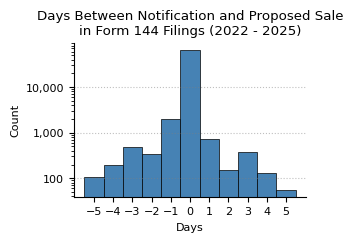

In [36]:
structured_data["filedAtDate"] = pd.to_datetime(structured_data["filedAt"].dt.date)
structured_data["daysBetweenNotificationAndSale"] = (
    structured_data["firstProposedDate"] - structured_data["filedAtDate"]
).dt.days

plot_hist(
    structured_data["daysBetweenNotificationAndSale"].loc[
        structured_data["daysBetweenNotificationAndSale"].between(-5, 5)
    ],
    title=f"Days Between Notification and Proposed Sale\n"
    f"in {form_name} Filings ({min_year} - {max_year})",
    x_label="Days",
    y_label="Count",
    ylog_scale=True,
    bins=np.arange(-6, 6) + 0.5,
    xticks=np.arange(-5, 6),
)
plt.show()

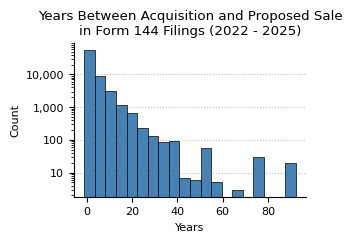

In [37]:
structured_data["yearsBetweenAcquisitionAndSale"] = (
    structured_data["firstProposedDate"] - structured_data["acquiredDate"]
).dt.days / 365.2425

plot_hist(
    structured_data["yearsBetweenAcquisitionAndSale"],
    title=f"Years Between Acquisition and Proposed Sale\n"
    f"in {form_name} Filings ({min_year} - {max_year})",
    x_label="Years",
    y_label="Count",
    ylog_scale=True,
    bins=20,
)
plt.show()